# Atmospheric Dispersion Examples

This notebook will demonstrate how to compute the effects of atmospheric refraction for solar observations. The routines used herein are based on IDL routines written by Kevin Reardon in 2006.

atmospheric_density: Given temperature, pressure, etc., return atmospheric density (needed for refractivity)

refractivity: Given temperature, pressure, etc., return refractivity (needed for atmospheric_refraction)

atmospheric_refraction: Compute magnitude of refraction and parallactic angle for given wavelengths at given times

offsets: Compute refraction offsets in solar disk NS-EW coordinates

## Load important modules

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import python_all as adm # Atmospheric Dispersion Module
import astropy.units as u
from astropy import coordinates
from astropy.coordinates import EarthLocation, AltAz, TETE
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator
from astropy.time import Time
from sunpy import coordinates as coord
import sunpy as sp
from scipy import interpolate
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

## Example 1: calculate refractivity for a single wavelength

In [55]:
# "average" atmospheric conditions on Haleakala
temp         = 11.*u.deg_C       # degrees Celsius
pressure     = 71100*u.pascal     # Pascals
humidity     = 30.       # percent
co2          = 380.      # ppm

# wavelength(s) for which refractivity will be computed; in this case, the calcium H line
wavelengths = np.array([396.9])*u.nm

refrac = adm.refractivity(wavelengths,temp,pressure,humidity,co2,verbose=2)

print("Refractivity (n-1) = {:.5g}".format(refrac[0])) # print refractivity to 5 sig. figs.

density a -  0.8670712923452407 1.2254226533684582 0.7075691721234494
density w -  0.003013028303143761 0.009859381090734688 0.30560014623790555
n(axs):  [28291.41881446] 
n(ws):  [318.58190157] 
rho(a/axs):  0.7075691721234494 
rho(w/ws):  0.30560014623790555 
n(prop):  [20115.49446446]
n(air):  [20018.13578875] 
n(water):  [97.35867571]
Refractivity (n-1) = 0.00020115


## Example 2: compute atmospheric refraction for a range of wavelengths at a single time

Text(0, 0.5, 'dispersion [arcsec]')

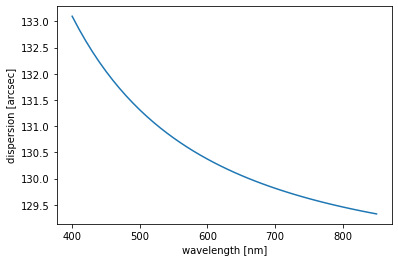

In [56]:
# Define location on Earth; in this case, we will use Haleakalā
longitude =    -156.25*u.deg
latitude  =     20.71*u.deg
altitude  =     3055.*u.m
haleakala = EarthLocation(lat=latitude, lon=longitude, height=altitude)

# series of wavelengths, ranging from 400 to 850 nm
wavelengths = (np.arange(46)*10 + 400) * u.nm

# time for which refraction will be computed; note that Hawaii time is UTC-10
time = Time('2021-11-15 18:00:00',scale='utc') + np.zeros((1))
time.format = 'jd'

# Compute dispersion for given times and wavelengths
dispersion = adm.atmospheric_refraction(wavelengths, time, air_pressure=pressure, air_temp=temp, 
                                         humidity=humidity,co2_conc=co2, latitude=latitude, 
                                         longitude=longitude,altitude=altitude,verbose=0)

# Plot dispersion as a function of wavelength
plt.plot(wavelengths.value,dispersion[0]['refraction_mag (arcsec)'][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('dispersion [arcsec]')

## Example 3: compute dispersion-induced offsets in solar NS-EW coordinates

270


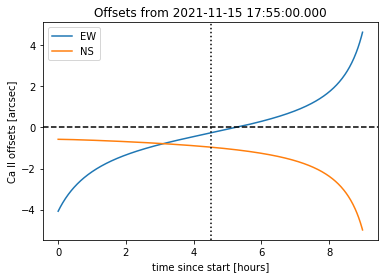

In [91]:
# Let's use two wavelengths: the calcium lines at 397 and 854 nm
wavelengths = np.array([396.8,854.2]) * u.nm

# We'll use the same location, but this time we'll calculate how the values change over several hours
# Again, note that Hawaii time is UTC-10, so e.g. 18:00 UTC is 08:00 a.m. in Hawaii
times = Time('2021-11-15 17:55:00', scale='utc') + np.arange(60*9) * u.min
times.format = 'jd'
noon_idx = int(np.where(np.modf((times-10*u.hour).value)[0]==0)[0][0] + (15 - longitude.value % 15)*4)

# Compute offsets
offsets = adm.offsets(wavelengths, times, air_pressure=pressure, air_temp=temp, humidity=humidity, 
                      co2_conc=co2, latitude=latitude, longitude=longitude,altitude=altitude,verbose=0)

# Plot difference of offsets, i.e. relative dispersion between the two wavelengths
EW = offsets['East-West']
NS = offsets['North-South']
T_delta = times - times[0]
plt.plot(T_delta.value * 24,EW[:,0]-EW[:,1],label='EW')
plt.plot(T_delta.value * 24,NS[:,0]-NS[:,1],label='NS')
plt.axhline(0,color='k',linestyle='--')
plt.axvline(T_delta[noon_idx].value * 24,color='k',linestyle=':')
plt.xlabel('time since start [hours]')
plt.ylabel('Ca II offsets [arcsec]')
plt.title('Offsets from ' + times[0].iso)
plt.legend()